# 11 — Hyperparameter Tuning Playbook

Purpose: learn a disciplined manual tuning workflow (no libraries) using structured experiment logging. You will tune `lr`, hidden width, and L2 strength on a synthetic dataset and pick a robust configuration.

## Learning goals
- Identify common hyperparameters and what they control.
- Apply a tuning workflow: baseline → fix data pipeline → tune lr → tune capacity → tune regularization.
- Record experiments consistently (config + metrics + notes).
- Choose “good enough” by validation metrics and stability, not by chasing tiny improvements.

## Prerequisites
- Notebook 10 (MLP training loop).
- Notebook 08 (train/val separation).
- Comfort with running multiple experiments quickly.

## Key ideas
- Tuning without logging is guessing.
- Start by tuning learning rate before changing architecture.
- Prefer a config that is stable across seeds/splits over a config that is brittle.
- Validation is for decisions; test is for reporting.

## Minimal theory
- Hyperparameters are not learned: `lr`, steps, hidden width, L2, early-stopping patience.
- Typical failure modes:
  - `lr` too high: diverges/oscillates
  - `lr` too low: slow learning
  - too much capacity: overfit
  - too much regularization: underfit

In [3]:
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
rng = np.random.default_rng(SEED)

def relu(z):
    return np.maximum(0.0, z)

def drelu(z):
    return (z > 0).astype(float)

def softmax_logsumexp(z):
    m = np.max(z, axis=1, keepdims=True)
    exp = np.exp(z - m)
    return exp / np.sum(exp, axis=1, keepdims=True)

def softmax_ce_from_logits(z, y_onehot):
    m = np.max(z, axis=1, keepdims=True)
    logsumexp = m + np.log(np.sum(np.exp(z - m), axis=1, keepdims=True))
    log_softmax = z - logsumexp
    return float(-np.mean(np.sum(y_onehot * log_softmax, axis=1, keepdims=True)))

def standardize_fit(x):
    mu = x.mean(axis=0, keepdims=True)
    sigma = x.std(axis=0, keepdims=True) + 1e-12
    return mu, sigma

def standardize_apply(x, mu, sigma):
    return (x - mu) / sigma

def split_train_val(x, y_idx, val_ratio=0.25, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    N = x.shape[0]
    idx = rng.permutation(N)
    n_val = int(N*val_ratio)
    va = idx[:n_val]
    tr = idx[n_val:]
    return x[tr], y_idx[tr], x[va], y_idx[va]

def make_3class_blobs(N=900, rng=None):
    rng = np.random.default_rng(0) if rng is None else rng
    n = N // 3
    x0 = rng.normal(loc=(-1.2, 0.0), scale=0.6, size=(n,2))
    x1 = rng.normal(loc=(+1.2, 0.2), scale=0.6, size=(n,2))
    x2 = rng.normal(loc=(0.0, 1.4), scale=0.6, size=(n,2))
    x = np.vstack([x0, x1, x2])
    y_idx = np.array([0]*n + [1]*n + [2]*n)
    idx = rng.permutation(N)
    return x[idx], y_idx[idx]

def onehot(y_idx, C):
    y = np.zeros((y_idx.shape[0], C))
    y[np.arange(y_idx.shape[0]), y_idx] = 1.0
    return y

def forward(x, W1, b1, W2, b2):
    z1 = x @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    return z1, a1, z2

def loss_and_grads(x, y_onehot, W1, b1, W2, b2, l2=0.0):
    N = x.shape[0]
    z1, a1, z2 = forward(x, W1, b1, W2, b2)
    p = softmax_logsumexp(z2)
    L = softmax_ce_from_logits(z2, y_onehot) + l2*(np.sum(W1*W1)+np.sum(W2*W2))
    dz2 = (p - y_onehot) / N
    dW2 = a1.T @ dz2 + 2*l2*W2
    db2 = np.sum(dz2, axis=0, keepdims=True)
    da1 = dz2 @ W2.T
    dz1 = da1 * drelu(z1)
    dW1 = x.T @ dz1 + 2*l2*W1
    db1 = np.sum(dz1, axis=0, keepdims=True)
    return L, {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

def predict(x, W1, b1, W2, b2):
    _, _, z2 = forward(x, W1, b1, W2, b2)
    p = softmax_logsumexp(z2)
    return np.argmax(p, axis=1)

def run_experiment(x_tr, y_tr, x_va, y_va, H, lr, steps, l2):
    C = int(np.max(y_tr)) + 1
    y_tr_oh = onehot(y_tr, C)
    y_va_oh = onehot(y_va, C)
    D = x_tr.shape[1]
    W1 = rng.normal(0, 0.4, size=(D,H))
    b1 = np.zeros((1,H))
    W2 = rng.normal(0, 0.4, size=(H,C))
    b2 = np.zeros((1,C))

    trL = []
    for _ in range(steps):
        L, grads = loss_and_grads(x_tr, y_tr_oh, W1, b1, W2, b2, l2=l2)
        W1 -= lr*grads['dW1']
        b1 -= lr*grads['db1']
        W2 -= lr*grads['dW2']
        b2 -= lr*grads['db2']
        trL.append(L)

    # metrics
    pred_tr = predict(x_tr, W1, b1, W2, b2)
    pred_va = predict(x_va, W1, b1, W2, b2)
    acc_tr = float((pred_tr == y_tr).mean())
    acc_va = float((pred_va == y_va).mean())
    L_va = softmax_ce_from_logits((relu(x_va @ W1 + b1) @ W2 + b2), y_va_oh) + l2*(np.sum(W1*W1)+np.sum(W2*W2))
    return {'acc_tr': acc_tr, 'acc_va': acc_va, 'L_va': float(L_va), 'L_tr_last': float(trL[-1])}

x, y = make_3class_blobs(N=900, rng=rng)
x_tr, y_tr, x_va, y_va = split_train_val(x, y, rng=rng)
mu, sig = standardize_fit(x_tr)
x_tr = standardize_apply(x_tr, mu, sig)
x_va = standardize_apply(x_va, mu, sig)

print('Shapes:', x_tr.shape, y_tr.shape, x_va.shape, y_va.shape)

Shapes: (675, 2) (675,) (225, 2) (225,)


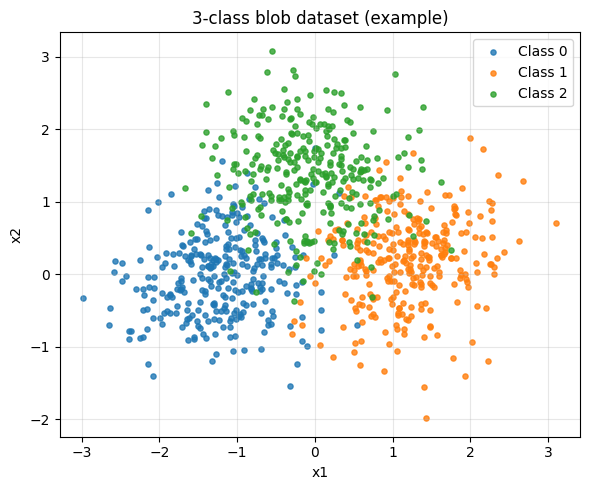

In [4]:
plt.figure(figsize=(6, 5))
for k in range(3):
    mask = y == k
    plt.scatter(x[mask, 0], x[mask, 1], s=14, label=f'Class {k}', alpha=0.8)
plt.title('3-class blob dataset (example)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step-by-step experiments
1. Define a small search space for `lr`, `H`, `l2`.
2. Run a grid (small by design for <2 minutes).
3. Log each run as a dict: config + metrics.
4. Plot validation accuracy vs learning rate and pick stable winners.
5. Re-run best configs once to confirm (same seed here for determinism).

Top 10 runs:
{'lr': 0.1, 'H': 2, 'l2': 0.1, 'acc_tr': 0.9111111111111111, 'acc_va': 0.8755555555555555, 'L_va': 0.9095345674473931, 'L_tr_last': 0.8971162816883224, 'notes': ''}
{'lr': 0.05, 'H': 2, 'l2': 0.1, 'acc_tr': 0.9081481481481481, 'acc_va': 0.8755555555555555, 'L_va': 0.9105324310292127, 'L_tr_last': 0.9010226206897858, 'notes': ''}
{'lr': 0.05, 'H': 128, 'l2': 0.0, 'acc_tr': 0.9051851851851852, 'acc_va': 0.8711111111111111, 'L_va': 0.31876525803169486, 'L_tr_last': 0.22921521320321644, 'notes': ''}
{'lr': 0.2, 'H': 64, 'l2': 0.0, 'acc_tr': 0.9125925925925926, 'acc_va': 0.8711111111111111, 'L_va': 0.32241480154274543, 'L_tr_last': 0.22590917753528855, 'notes': ''}
{'lr': 0.05, 'H': 2, 'l2': 0.0001, 'acc_tr': 0.9081481481481481, 'acc_va': 0.8711111111111111, 'L_va': 0.3227773539716953, 'L_tr_last': 0.24809938609602433, 'notes': ''}
{'lr': 0.35, 'H': 64, 'l2': 0.0001, 'acc_tr': 0.914074074074074, 'acc_va': 0.8711111111111111, 'L_va': 0.3240149525776716, 'L_tr_last': 0.2331861638

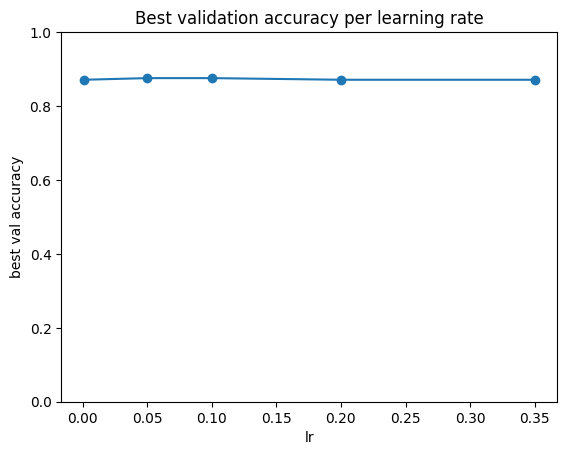

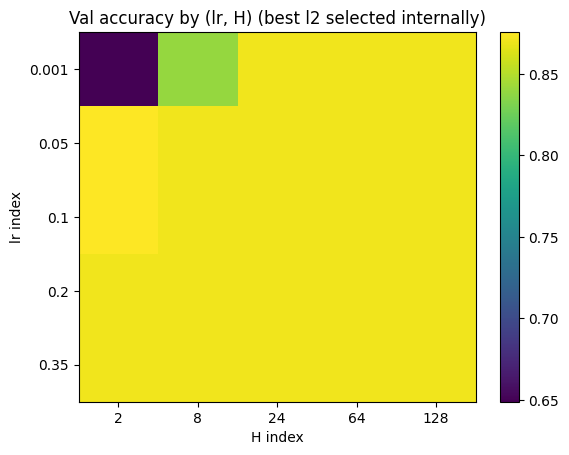

In [6]:
search_lr = [0.001, 0.05, 0.1, 0.2, 0.35]
search_H = [2, 8, 24, 64, 128]
search_l2 = [0.0, 1e-4, 1e-3, 1e-2, 1e-1]
steps = 1400

runs = []
for lr in search_lr:
    for H in search_H:
        for l2 in search_l2:
            metrics = run_experiment(x_tr, y_tr, x_va, y_va, H=H, lr=lr, steps=steps, l2=l2)
            runs.append({
                'lr': lr,
                'H': H,
                'l2': l2,
                **metrics,
                'notes': ''
            })

# Sort by validation accuracy then validation loss
runs_sorted = sorted(runs, key=lambda r: (-r['acc_va'], r['L_va']))
print('Top 10 runs:')
for r in runs_sorted[:10]:
    print(r)

# Plot 1: validation accuracy vs lr (aggregated by best over H,l2 for each lr)
best_by_lr = []
for lr in search_lr:
    candidates = [r for r in runs if r['lr'] == lr]
    best = sorted(candidates, key=lambda r: (-r['acc_va'], r['L_va']))[0]
    best_by_lr.append((lr, best['acc_va']))

plt.figure()
plt.plot([t[0] for t in best_by_lr], [t[1] for t in best_by_lr], marker='o')
plt.title('Best validation accuracy per learning rate')
plt.xlabel('lr')
plt.ylabel('best val accuracy')
plt.ylim(0,1)
plt.show()

# Plot 2: val accuracy heatmap-ish by H for the best l2 per (lr,H)
vals = np.zeros((len(search_lr), len(search_H)))
for i, lr in enumerate(search_lr):
    for j, H in enumerate(search_H):
        candidates = [r for r in runs if r['lr']==lr and r['H']==H]
        best = sorted(candidates, key=lambda r: (-r['acc_va'], r['L_va']))[0]
        vals[i,j] = best['acc_va']

plt.figure()
plt.imshow(vals, aspect='auto')
plt.title('Val accuracy by (lr, H) (best l2 selected internally)')
plt.xlabel('H index')
plt.ylabel('lr index')
plt.xticks(range(len(search_H)), [str(h) for h in search_H])
plt.yticks(range(len(search_lr)), [str(lr) for lr in search_lr])
plt.colorbar()
plt.show()

## Reflection questions
1. Which hyperparameter had the largest impact here, and why?
2. What is your tuning order for a new problem and why?
3. Why should you keep the search space small initially?
4. How would you store the `runs` log in a real project?
5. What would you change if train accuracy is high but val accuracy is low?

## Optional extensions
1. Add early stopping and tune patience.
2. Repeat tuning with a different seed and compare stability.
3. Add a small “time budget” and stop search early when improvements plateau.

## Summary
- Hyperparameter tuning needs a workflow and logging.
- Tune learning rate early; it often dominates outcomes.
- Capacity and regularization trade off fit vs generalization.
- Prefer stable, repeatable configs over marginal wins.
- Next: evaluation, inference, and real-world pitfalls.